In [238]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [231]:
def create_dataset(dataset, true_price, look_back = 1, look_forward = 1):
      
    # MinMax
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    #dataset = min_max_scaler.fit_transform(dataset)
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)

    
    #print(dataset)
    lookback = look_back
    trueprice = []
    datax = []
    datay = []

    for i,v in enumerate(dataset):
        if i > lookback + look_forward:
            datax.append([dataset[i-j] for j in range(lookback+look_forward, look_forward, -1)])
            datay.append([true_price[i-j] for j in range(look_forward, 0, -1)])   
    
    trueprice = [i for i in true_price]
 
    
    datax = np.array(datax)
    datay = np.array(datay)
    trueprice = np.array(trueprice)
    
    # Standardize y data for å skille dem fra hverandre
   
    #print(datay.shape)
    mean = [1 for _ in range(datay.shape[1])]
    std = [0.0006 for _ in range(datay.shape[1])]
    #mean = datay.mean(axis=0)
    datay -= mean
    trueprice -= mean[0]
    
    #std = datay.std(axis=0)
    
    datay /= std
    trueprice /= std[0]

    print(datax.shape)
    
    
    # Normalize
    #datax = preprocessing.normalize(datax)
    #datay = preprocessing.normalize(datay)
    
    # reshape input to be [samples, time steps, features]
    #datax = np.reshape(datax, (datax.shape[0], lookback, 1))
    
    return datax, datay, trueprice

In [17]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_5_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma5_derivert'] = [stock.open_5_sma[i] / stock.open_5_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_5_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        #break # må tas bort ettervært
        stocks.append(stock)
    
    return stocks

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [239]:
filer = list(map(add_data, os.listdir('data/')))[1:10] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [240]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)
    


(197, 30, 5)
(336, 30, 5)
(317, 30, 5)
(369, 30, 5)
(394, 30, 5)
(245, 30, 5)
(367, 30, 5)
(255, 30, 5)
(332, 30, 5)


In [233]:
datax # ide: Ta siste x for å finne neste y. Del opp datasettet der etter

array([[[ 1.61275502e-01,  3.88085713e+00, -4.30029360e-02,
          7.11015472e+00,  1.41433322e+00],
        [ 1.00075670e-01,  1.39267517e+00, -4.30029360e-02,
          4.03788109e+00,  5.70076569e-01],
        [ 5.05779610e-02,  1.14808896e+00, -4.30029360e-02,
          2.56962204e+00,  5.58463201e-01],
        ...,
        [-3.31876345e-02,  7.42921303e-03,  6.47832965e-01,
         -2.18430119e-02, -1.22150536e-01],
        [-1.47604057e-01, -2.63266433e-01,  2.47875338e-01,
         -7.04135144e-02, -7.67528260e-02],
        [-2.73261099e-01, -3.91588169e-01, -3.70240994e-01,
         -1.42776303e-01,  1.47948245e-01]],

       [[ 1.00075670e-01,  1.39267517e+00, -4.30029360e-02,
          4.03788109e+00,  5.70076569e-01],
        [ 5.05779610e-02,  1.14808896e+00, -4.30029360e-02,
          2.56962204e+00,  5.58463201e-01],
        [ 1.58692040e-03,  9.13465086e-01, -4.30029360e-02,
          1.70523216e+00, -1.89015381e-01],
        ...,
        [-1.47604057e-01, -2.6326643

In [241]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(input_dim=dataxes[0].shape[2], units=256, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=256, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(datayes[0].shape[1]))

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 256)         268288    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 796,170
Trainable params: 796,170
Non-trainable params: 0
_________________________________________________________________


In [242]:
all_history = []
for i in range(len(dataxes)):
    print(f"{i+1} of {len(dataxes)}")
    history = model.fit(dataxes[i], datayes[i], epochs=10, batch_size=64, verbose=2)#,
         ##callbacks= [keras.callbacks.EarlyStopping(
                                  #  monitor='val_loss', patience=10, restore_best_weights=True)])
    all_history.append(history.history['loss'])

Train on 197 samples
Epoch 1/10
197/197 - 12s - loss: 0.5137
Epoch 2/10
197/197 - 2s - loss: 0.3552
Epoch 3/10
197/197 - 2s - loss: 0.3224
Epoch 4/10
197/197 - 2s - loss: 0.2975
Epoch 5/10
197/197 - 2s - loss: 0.2829
Epoch 6/10
197/197 - 2s - loss: 0.2621
Epoch 7/10
197/197 - 2s - loss: 0.2549
Epoch 8/10
197/197 - 2s - loss: 0.2566
Epoch 9/10
197/197 - 2s - loss: 0.2564
Epoch 10/10
197/197 - 2s - loss: 0.2318
Train on 336 samples
Epoch 1/10
336/336 - 3s - loss: 0.3725
Epoch 2/10
336/336 - 3s - loss: 0.3107
Epoch 3/10
336/336 - 3s - loss: 0.2750
Epoch 4/10
336/336 - 3s - loss: 0.2577
Epoch 5/10
336/336 - 3s - loss: 0.2358
Epoch 6/10
336/336 - 3s - loss: 0.2282
Epoch 7/10
336/336 - 3s - loss: 0.2161
Epoch 8/10
336/336 - 3s - loss: 0.2059
Epoch 9/10
336/336 - 3s - loss: 0.2035
Epoch 10/10
336/336 - 3s - loss: 0.2004
Train on 317 samples
Epoch 1/10
317/317 - 3s - loss: 0.1973
Epoch 2/10
317/317 - 3s - loss: 0.1067
Epoch 3/10
317/317 - 3s - loss: 0.0896
Epoch 4/10
317/317 - 3s - loss: 0.078

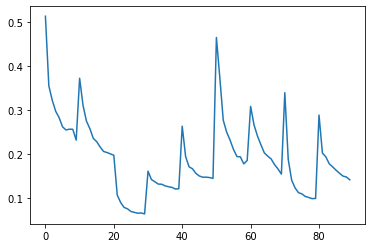

In [246]:
#plt.plot(history.history['loss'])
flatten = [j for sub in all_history for j in sub]
#all_history
#for h in all_history:
plt.plot(flatten)

In [234]:
predicts = []
for i in dataxes:
    predict = model.predict(i)
    predicts.append(predict)

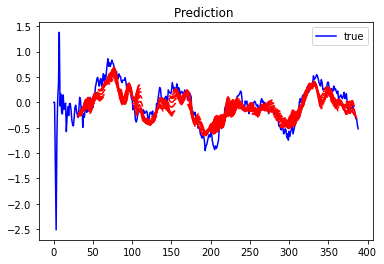

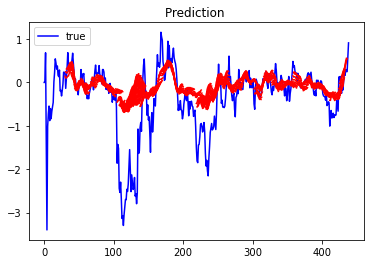

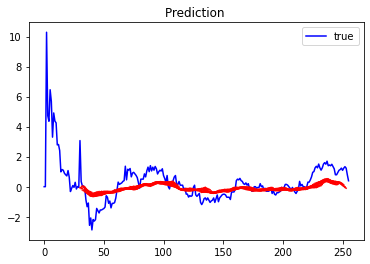

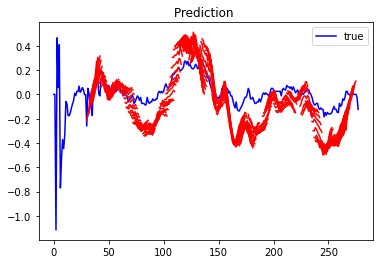

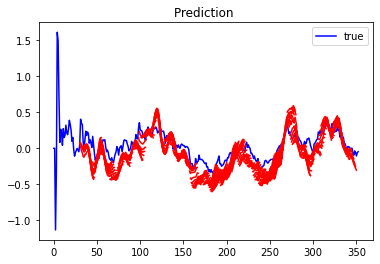

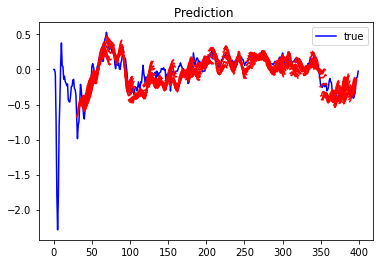

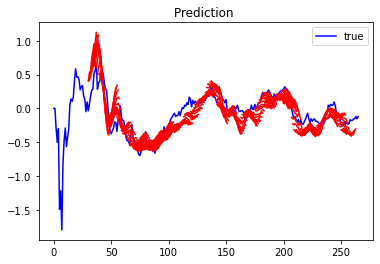

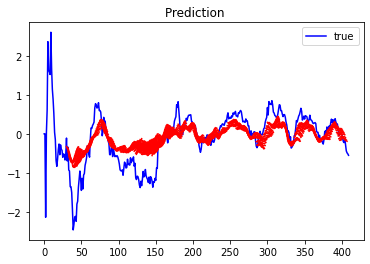

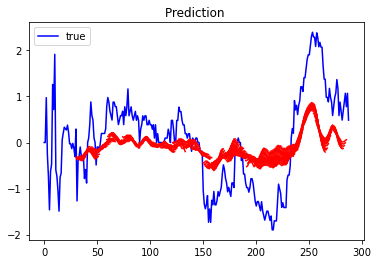

In [235]:
for j in range(len(dataxes)):
    plt.plot(sanne[j], c='blue', label='true')
    for i in range(len(datayes[j])):
        plt.plot(range(i+look_back,i+look_back+look_forward), predicts[j][i], c='red')

    plt.legend()
    plt.title('Prediction ')
    #plt.savefig('images/RNN_15_ahead')
    plt.show()


In [214]:
predict[0]

array([0.69334054, 0.5858242 , 0.57565075, 0.50590146, 0.5145738 ,
       0.5676173 , 0.4426812 , 0.4868359 , 0.5041089 , 0.50749564],
      dtype=float32)

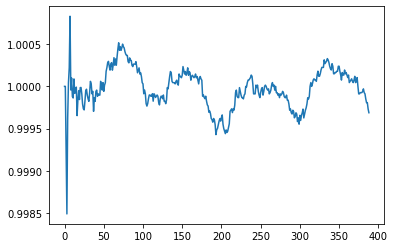

In [237]:
plt.plot(data[0].sma30_derivert)
#plt.plot(data.sma5_derivert)

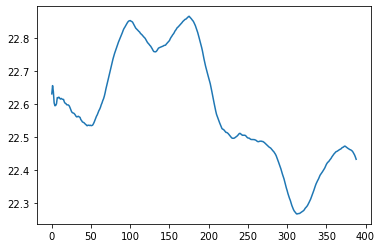

In [236]:
plt.plot(data[0].open_30_sma)
#plt.plot(data.sma5_derivert)

In [53]:
# Save model

#model.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model\assets


In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
